In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pyfftw
import re

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

2024-07-18 12:00:53.932102: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 12:00:54.230206: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 12:00:54.232323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 12:00:57.542154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-18 12:01:02.206224: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [47]:
save_plots = True
plot_dir = '../plots/plots_2024-07-17'

## Load and prep emu

In [2]:
# emu_mpk_ext, emu_bounds_mpk_ext, emu_param_names_mpk_ext = utils.load_emu(emu_name='mpk_extended')
# emu_bounds_dict_mpk_ext = dict(zip(emu_param_names_mpk_ext, emu_bounds_mpk_ext))
emu, emu_bounds, emu_param_names = utils.load_emu()
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Load lib and compute p(k)s

In [64]:
# order of saved cosmo param files
# param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
# param_names = ['omega_cold', 'sigma_8', 'h']
# param_names_fixed = [name for name in param_names_all if name not in param_names]
# idxs_param_names = [param_names_all.index(name) for name in param_names]

n_grid = 128
n_grid_orig = 512
box_size = 1000.0

tag_params = '_p3_n500'
tag_mocks = tag_params
tag_fields = '_deconvolved'
dir_mocks = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks}'

title_tag = ', b=[1,0,0,0]'
tag_pk = '_b1000'
tag_pk_zspace = '_b1000_zspace'
dir_pks = f'../data/pks_mlib/pks{tag_mocks}{tag_pk}'
dir_pks_zspace = f'../data/pks_mlib/pks{tag_mocks}{tag_pk_zspace}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

# idxs_LH = np.sort([int(re.search(r'LH(\d+)', dir_mocks).group(1)) \
#         for dir_mocks in os.listdir(dir_mocks) \
#         if re.search(r'LH\d+', dir_mocks)])
# idxs_LH = np.sort([int(re.search(r'_(\d+)', dir_pks_zspace).group(1)) \
#         for dir_pks_zspace in os.listdir(dir_pks_zspace) \
#         if re.search(r'_\d+', dir_pks_zspace)])
idxs_LH = np.arange(100)
print(idxs_LH)
print(len(idxs_LH))
#idxs_LH = np.arange(100)
#idxs_LH = np.arange(1)
n_lib = len(idxs_LH)

fn_params = f'{dir_mocks}/params_lh{tag_params}.txt'
fn_params_fixed = f'{dir_mocks}/params_fixed{tag_params}.txt'
params_df = pd.read_csv(fn_params, index_col=0)
param_dict_fixed = pd.read_csv(fn_params_fixed).loc[0].to_dict()


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
100


### Load data 

In [66]:
theta = []
Pk = []
Pk_zspace = []
gaussian_error_pk = []
gaussian_error_pk_zspace = []

param_names = params_df.columns.to_list()

for idx_LH in idxs_LH:
    #fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
    #fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
    fn_pk = f'{dir_pks}/pk_{idx_LH}.npy'
    fn_pk_zspace = f'{dir_pks_zspace}/pk_{idx_LH}.npy'
    
    pk_obj = np.load(fn_pk, allow_pickle=True).item()
    Pk.append(pk_obj['pk'])
    gaussian_error_pk.append(pk_obj['pk_gaussian_error'])
    
    pk_obj_zspace = np.load(fn_pk_zspace, allow_pickle=True).item()
    Pk_zspace.append(pk_obj_zspace['pk'])
    gaussian_error_pk_zspace.append(pk_obj_zspace['pk_gaussian_error'])
    
    param_dict = params_df.loc[idx_LH].to_dict()
    theta.append( np.array([param_dict[pn] for pn in param_names]) )

Pk = np.array(Pk)
Pk_zspace = np.array(Pk_zspace)
theta = np.array(theta)
gaussian_error_pk = np.array(gaussian_error_pk)

kk = pk_obj['k'] # all ks should be same so just grab one
print(len(kk))
print(Pk.shape)

30
(100, 30)


In [67]:
# overall quantities
Pk_emu = []
for i, idx_LH in enumerate(idxs_LH):
    if i % 10 == 0:
        print(i)
    param_dict = params_df.loc[idx_LH].to_dict()
    param_dict.update(param_dict_fixed)
    cosmo_params_emu = utils.get_cosmo_emu(param_dict)
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=kk, 
                                                   cold=True, **cosmo_params_emu)
    Pk_emu.append(pk_model_unscaled)
    
Pk_emu = np.array(Pk_emu)
print(Pk_emu.shape)

0
10
20
30
40
50
60
70
80
90
(100, 30)


In [68]:
expfactor = 1.0
kaiser_boosts = []
for i, idx_LH in enumerate(idxs_LH):
    if i % 10 == 0:
        print(i)
    param_dict = params_df.loc[idx_LH].to_dict()
    cosmo = utils.get_cosmo(param_dict)
    # bias is the linear bias
    # kaiser boost only depends on k if neutrino mass is nonzero
    kaiser_boosts.append( cosmo.Kaiser_boost(expfactor, l=0, bias=bias_params[0]) )

0
10
20
30
40
50
60
70
80
90


In [69]:
kaiser_boosts = np.array(kaiser_boosts)
Pk_emu_zspace = Pk_emu * kaiser_boosts[:, np.newaxis] 
Pk_kaiserboosted = Pk * kaiser_boosts[:, np.newaxis] 

In [70]:
print(np.min(kaiser_boosts), np.max(kaiser_boosts))

1.3331766895335002 1.4735208275980074


## Plot

/tmp/ipykernel_74763/1759589267.py:41: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_74763/1759589267.py:42: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_74763/1759589267.py:48: RuntimeWarning: divide by zero encountered in divide
  diff_overG = diff_Pk/gaussian_error_pk
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_74763/1759589267.py:53: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x2ba1f626dbd0>, <ErrorbarContainer object of 3 artists>] ['emulated at true $\\theta$', 'map2map measured']
[<matplotlib.lines.Line2D object at 0x2ba2ca3adad0>, <matplotlib.lines.Line2D object at 0x2ba2c9b65710>] ['median', '16-84 percentile']


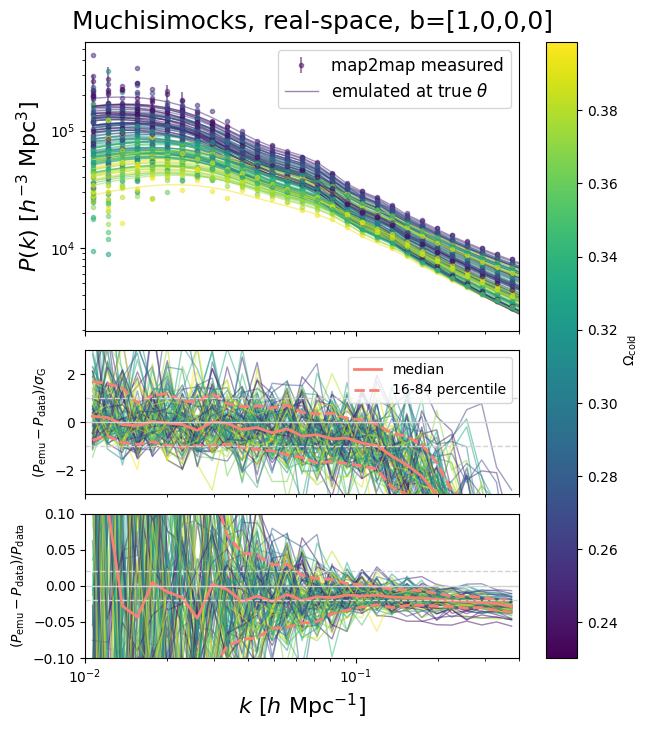

In [71]:
n_plot = n_lib

#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, real-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
        
        if first or show_error_all:
            axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        else:
            axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        axarr[0].plot(k, Pk_emu[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu - Pk
    diff_overG = diff_Pk/gaussian_error_pk
    diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    diff_overG_med = np.median(diff_overG, axis=0)

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overG_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overG_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overG_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-3, 3)
    axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{data})/P_\text{data}$', fontsize=10)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks{tag_pk}.png', bbox_inches='tight')

/tmp/ipykernel_74763/1995779735.py:48: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_74763/1995779735.py:49: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_74763/1995779735.py:59: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk_zspace
/tmp/ipykernel_74763/1995779735.py:69: RuntimeWarning: invalid value encountered in divide
  diff_overPk_realK = diff_Pk_realK/Pk_zspace


[<matplotlib.lines.Line2D object at 0x2ba2c9e6eb90>, <matplotlib.lines.Line2D object at 0x2ba192642710>, <matplotlib.lines.Line2D object at 0x2ba192643710>, <matplotlib.lines.Line2D object at 0x2ba1926438d0>, <matplotlib.lines.Line2D object at 0x2ba2c9b52350>, <matplotlib.lines.Line2D object at 0x2ba2ca467550>, <matplotlib.lines.Line2D object at 0x2ba2ca467a90>, <matplotlib.lines.Line2D object at 0x2ba2ca464050>, <matplotlib.lines.Line2D object at 0x2ba1f72ff010>, <matplotlib.lines.Line2D object at 0x2ba1f72fe950>, <matplotlib.lines.Line2D object at 0x2ba19333af50>, <matplotlib.lines.Line2D object at 0x2ba19333a850>, <matplotlib.lines.Line2D object at 0x2ba2ca8bf910>, <matplotlib.lines.Line2D object at 0x2ba2ca8be110>, <matplotlib.lines.Line2D object at 0x2ba2ca8bfa10>, <matplotlib.lines.Line2D object at 0x2ba192611890>, <matplotlib.lines.Line2D object at 0x2ba192611a90>, <matplotlib.lines.Line2D object at 0x2ba1926128d0>, <matplotlib.lines.Line2D object at 0x2ba1f63c7e90>, <matplotlib

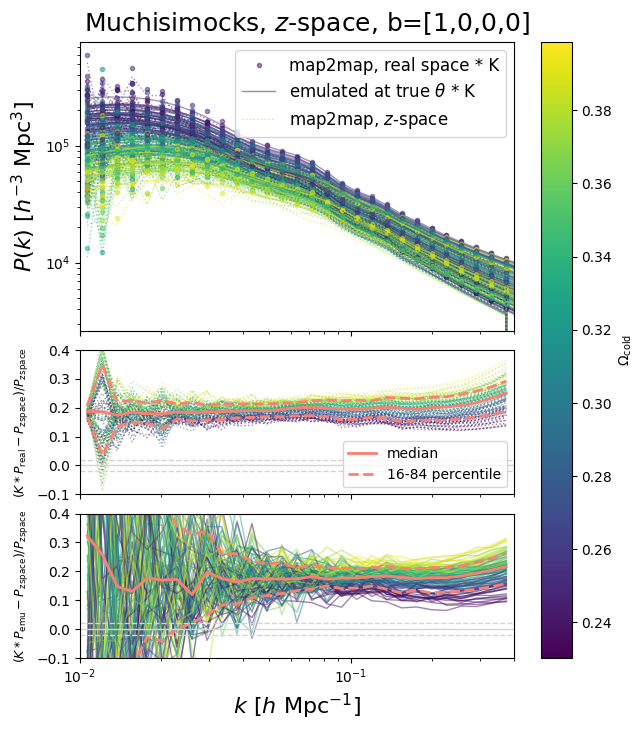

In [72]:
n_plot = n_lib

#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, $z$-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$ * K'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real_kb = 'map2map, real space * K'
            label_zspace = r'map2map, $z$-space'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_zspace[i], yerr=gaussian_error_pk_zspace[i], 
                            #ls='None', marker='o', markersize=3, alpha=0.5, label=label_zspace, color=colors[i],
                            ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw
                            )
        else:
            #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        axarr[0].plot(k, Pk_kaiserboosted[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real_kb, color=colors[i])
        axarr[0].plot(k, Pk_emu_zspace[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        #axarr[1].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/gaussian_error_pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu_zspace - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk = diff_Pk/Pk_zspace
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)
    
    diff_Pk_realK = Pk_kaiserboosted - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk_realK = diff_Pk_realK/Pk_zspace
    diff_overPk_realK_16 = np.percentile(diff_overPk_realK, 16, axis=0)
    diff_overPk_realK_84 = np.percentile(diff_overPk_realK, 84, axis=0)
    diff_overPk_realK_med = np.median(diff_overPk_realK, axis=0)


    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overPk_realK_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overPk_realK_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overPk_realK_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.1, 0.4)
    axarr[2].set_ylim(-0.1, 0.4)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [0,1,2]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    #axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[1].set_ylabel(r'$(K*P_\text{real}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
    axarr[2].set_ylabel(r'$(K*P_\text{emu}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_zspace{tag_pk_zspace}.png', bbox_inches='tight')

/tmp/ipykernel_74763/1000188505.py:47: RuntimeWarning: invalid value encountered in divide
  ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_74763/1000188505.py:54: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x2ba2c9d37150>, <matplotlib.lines.Line2D object at 0x2ba2c9d37110>] ['map2map, real space', 'map2map, $z$-space']
[<matplotlib.lines.Line2D object at 0x2ba1933fdf10>, <matplotlib.lines.Line2D object at 0x2ba1934b5210>] ['median', '16-84 percentile']


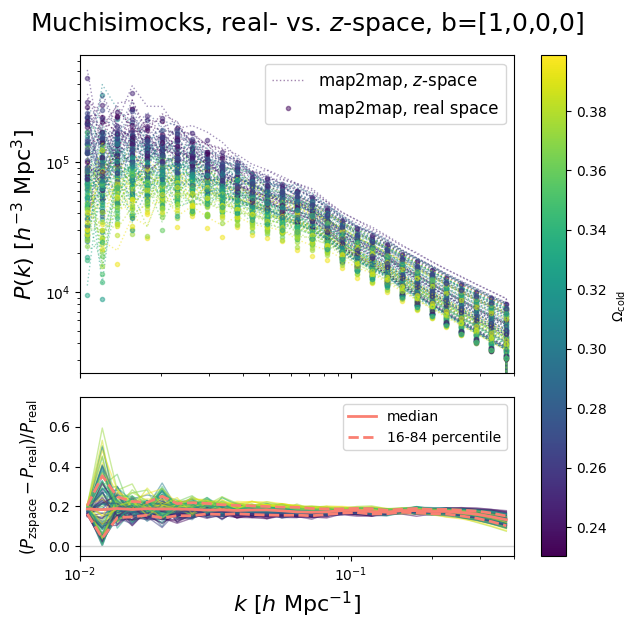

In [73]:
n_plot = n_lib

#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 2, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,6.5), sharex=True, height_ratios=[2,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1 = axarr
    
    fig.suptitle(fr"Muchisimocks, real- vs. $z$-space{title_tag}", y=0.95, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        label_real, label_zspace = None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real = 'map2map, real space'
            label_zspace = r'map2map, $z$-space'
        
        #axarr[0].plot(k, Pk[i], ls='--', alpha=0.5, label=label_real, color=colors[i], lw=lw)
        axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real, color=colors[i])
        #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='d', markersize=3, alpha=0.5, label=label_zspace, color=colors[i], markerfacecolor='None')
        axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        # if first or show_error_all:
        #     axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk_zspace[i], 
        #                     ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        # else:
        #     axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_zspace - Pk

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5

    ax1.plot(k, diff_overPk_med, color='salmon', lw=2, label='median')
    ax1.plot(k, diff_overPk_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    ax1.plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    color_hline = 'lightgrey'
    ax1.axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.05, 0.75)
    #axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)
    #axarr[1].legend(fontsize=10)

    ax1.legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    ax1.set_ylabel(r'$(P_\text{zspace}-P_\text{real})/P_\text{real}$', fontsize=12)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_vszspace{tag_pk}.png', bbox_inches='tight')